## Timeseries

https://pandas.pydata.org/pandas-docs/stable/timeseries.html

- generate sequences of fixed-frequency dates and time spans
- conform or convert time series to a particular frequency
- compute “relative” dates based on various non-standard time increments (e.g. 5 business days before the last - business day of the year), or “roll” dates forward or backward

<center>![alt text](images/Disruptive%20Technologies2.png)</center>

In [2]:
import pandas as pd
import requests
import io
import json
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [3]:
time_range = pd.date_range(start='2018.01.01', end='2018.1.3')
time_df = pd.DataFrame(index=time_range, data=[[23, 100],[26,94],[39,61]], columns=['temperature', 'battery'])
time_df
# plot

,temperature,battery
2018-01-01,23,100
2018-01-02,26,94
2018-01-03,39,61


#### Upsample to hourly sampling

In [36]:
# date_range
# reindex

In [5]:
time_range_h = pd.date_range(start='2018.01.01', end='2018.1.3', freq='H')
time_df_upsampled = time_df.reindex(time_range_h)
time_df_upsampled.head(10)

,temperature,battery
2018-01-01 00:00:00,23.0,100.0
2018-01-01 01:00:00,NaN,NaN
2018-01-01 02:00:00,NaN,NaN
2018-01-01 03:00:00,NaN,NaN
2018-01-01 04:00:00,NaN,NaN
2018-01-01 05:00:00,NaN,NaN
2018-01-01 06:00:00,NaN,NaN
2018-01-01 07:00:00,NaN,NaN
2018-01-01 08:00:00,NaN,NaN
2018-01-01 09:00:00,NaN,NaN


#### Interpolate hours between days 

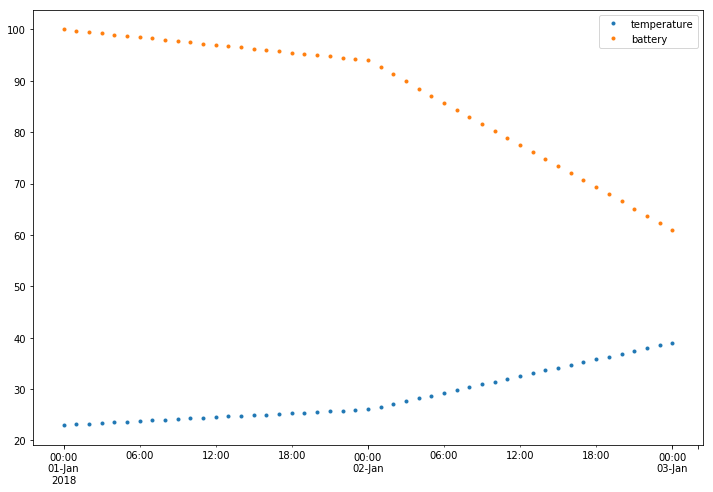

In [14]:
time_df_interpolated = time_df_upsampled.interpolate(method='linear')
time_df_interpolated.plot(style='.');

## Fridge touch sensor

In [17]:
thing_id = "206843648"
api_key = %env DT_API_KEY

In [18]:
url = "https://api.disruptive-technologies.com/v1/things/{thing_id}/aggregate".format(thing_id=thing_id)
headers = {
    'Authorization': 'ApiKey {api_key}'.format(api_key=api_key),
    'Cache-Control': 'no-cache',
    'Content-Type': 'application/json',
}
body = {}
body['interval'] = '1s'
body['time_period'] = {
'start': '2014-11-01T00:01:00Z',
'end': '2099-12-31T20:00:00Z'
}

jsonData = requests.post(url, headers=headers, data=json.dumps(body)).json()
normalized = pd.io.json.json_normalize(jsonData['values'])
df = pd.DataFrame.from_dict(normalized)
len(df)

141

In [20]:
#df.to_excel('dt_fridge_sensor_backup.xlsx')

#### Set timestamps as index

In [25]:
df = df.astype({'touch': 'int'})

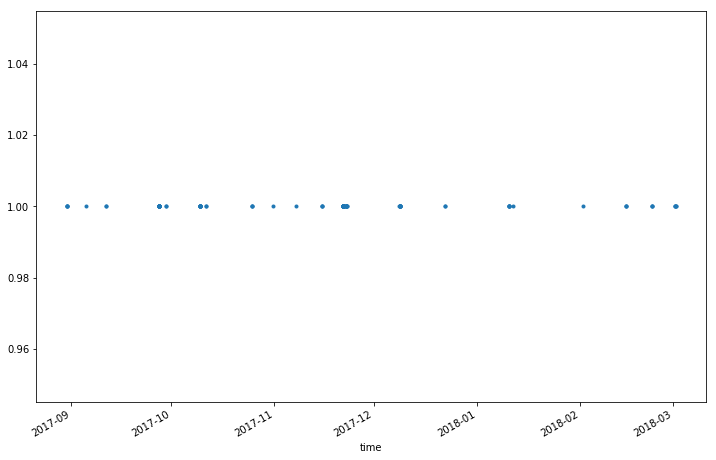

In [27]:
# convert from string to datetime
#df['time'] = pd.to_datetime(df.time)
#df.set_index('time', inplace=True)
#set index
# plot touch
df.touch.plot(style='.');

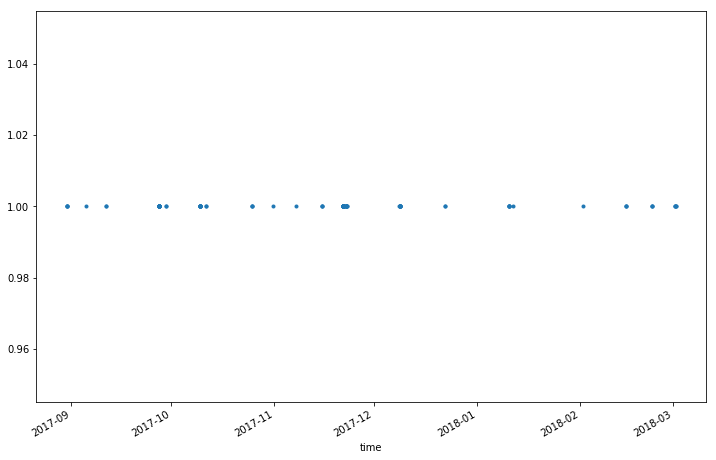

In [30]:
#df['time'] = pd.to_datetime(df.time)
#df = df.set_index('time')
ds_touch = df.touch
ds_touch.plot(style=".");

### Find a better way to visualize touch events

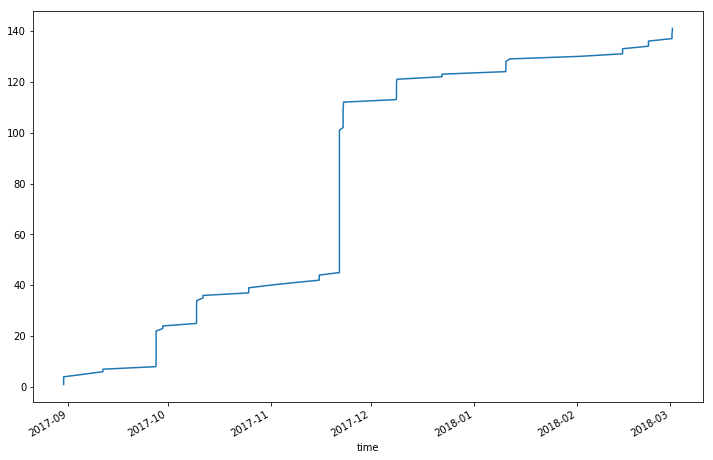

In [31]:
import numpy as np
df.apply(np.cumsum).touch.plot();

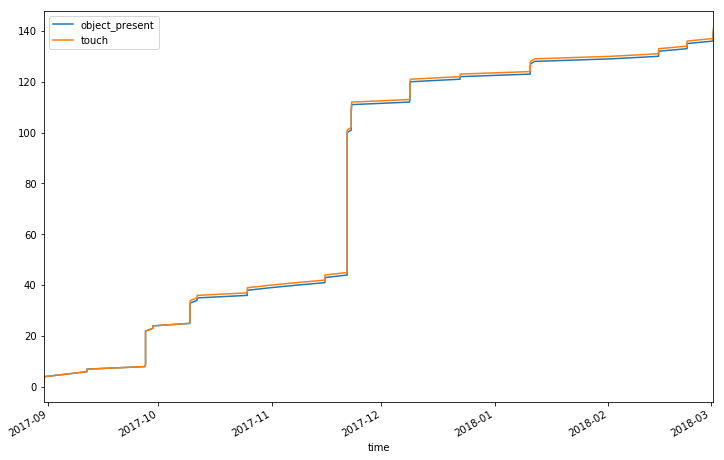

In [45]:
import numpy as np
df.apply(np.cumsum).plot();

### Resample timeseries

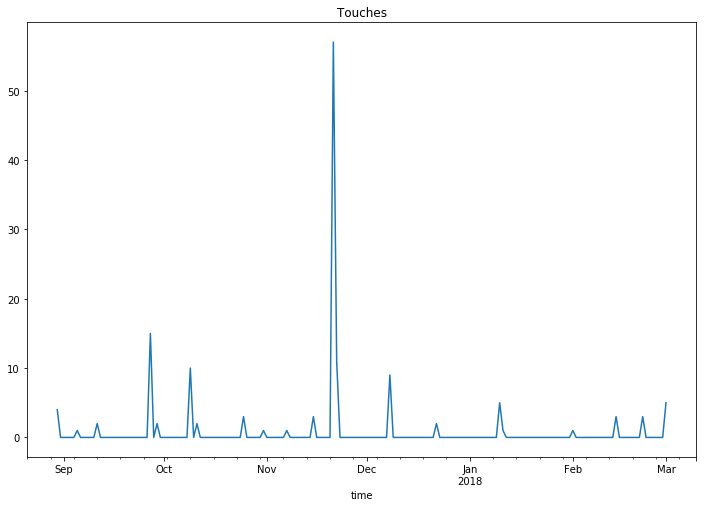

In [32]:
touch_day = df.touch.resample('D').count()
touch_day.plot(title='Touches');

### What was the day with highest touch frequency?

In [36]:
touch_day.idxmax()

Timestamp('2017-11-21 00:00:00', freq='D')

In [48]:
touch_day.idxmax()

Timestamp('2017-11-21 00:00:00', freq='D')

#### Resample minute

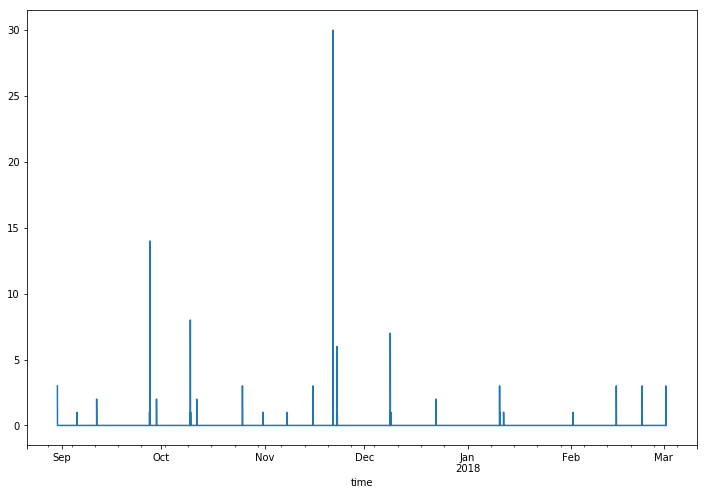

In [37]:
touch_min = df.touch.resample('min').count()
touch_min.plot();

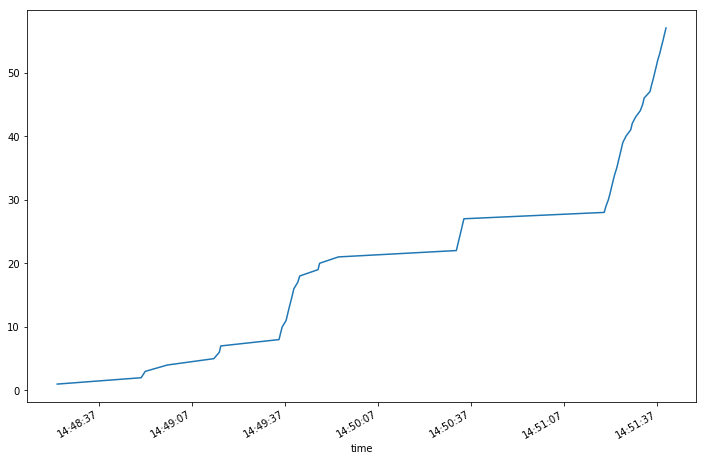

In [39]:
delta = pd.Timedelta('0 days 1 hours')
#delta = pd.Timedelta(hours=1)

idx = touch_min.idxmax()
touch_galore = df.loc[idx-delta:idx+delta]
touch_galore['touch'].cumsum().plot();

### Group by

Exhaustive resource: https://pandas.pydata.org/pandas-docs/stable/groupby.html

In [40]:
df.groupby('temperature').count()

,battery_percentage,battery_voltage,device_id,event_type,last_pressed,object_present,rssi,rssi_strength,thing_id,thing_type_id,touch
temperature,,,,,,,,,,,
24,10,10,10,10,10,10,10,10,10,10,10
27,91,91,91,91,91,91,91,91,91,91,91
28,40,40,40,40,40,40,40,40,40,40,40


#### Group by weekday

In [41]:
df['weekday'] = df.index.weekday

df.groupby('weekday').sum()

,object_present,touch
weekday,,
0,11.0,12
1,60.0,60
2,46.0,46
3,10.0,10
4,13.0,13


### Find source for disparity between `object_present` and `touch`

In [42]:
df[df['object_present'] == False]

,battery_percentage,battery_voltage,device_id,event_type,last_pressed,object_present,rssi,rssi_strength,temperature,thing_id,thing_type_id,touch,weekday
time,,,,,,,,,,,,,
2017-10-09 16:19:15.460441323,100,2.82,206843648,touch_trigger,2017-10-09 16:19:15.460441323 +0000 UTC,False,-83,3,27,206843648,touch,1,0


#### Map to weekday names

In [43]:
weekdays = ['Mandag', 'Tirsdag', 'Onsdag', 'Torsdag', 'Fredag', 'Lørdag', 'Søndag']
def to_weekday(i: int) -> str:
    return weekdays[i]
to_weekday(1)

'Tirsdag'

In [44]:
df['weekday'] = df['weekday'].apply(to_weekday)

#### Touch events by weekday

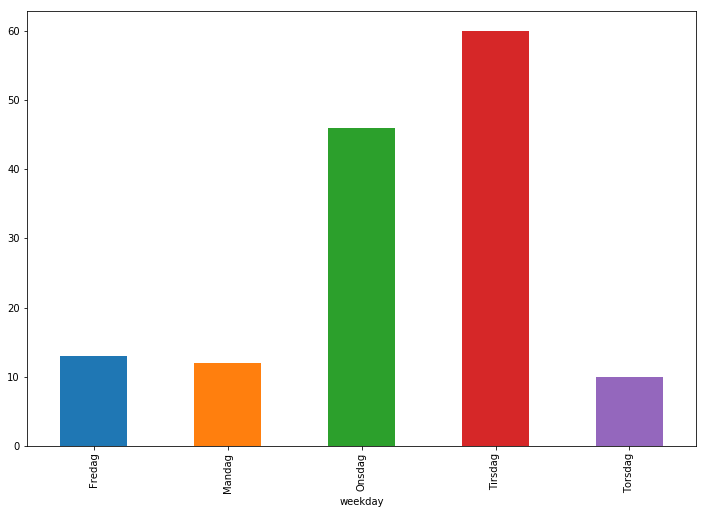

In [46]:
df.groupby('weekday').touch.count().plot(kind='bar');

#### Drop touch events from november 21th

In [47]:
len(df.drop(touch_galore.index)), len(df)

(84, 141)

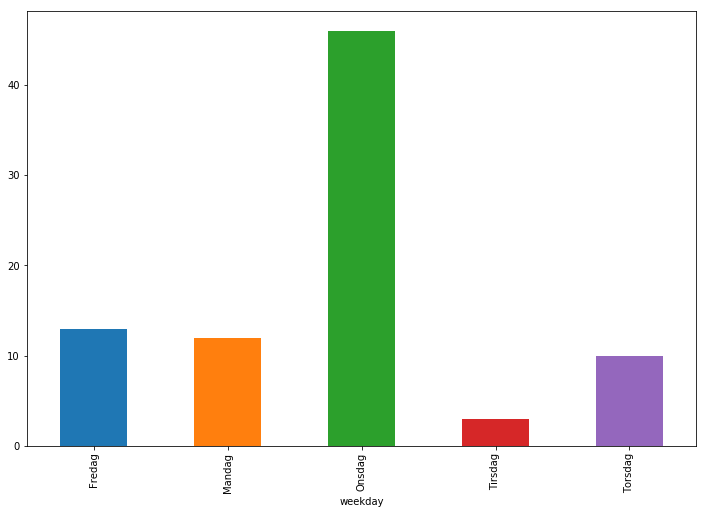

In [48]:
without_nov_21 = df.drop(touch_galore.index)

without_nov_21.groupby('weekday').touch.count().plot(kind='bar');

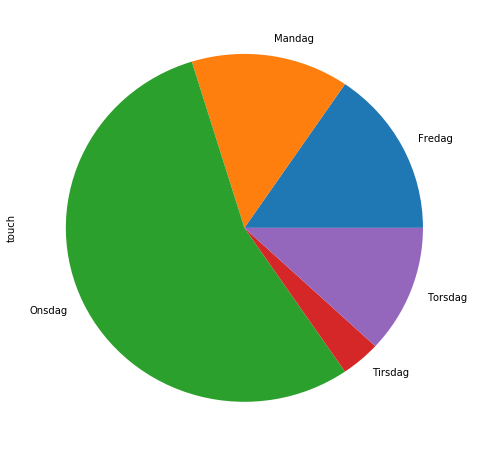

In [49]:
# try pie chart
without_nov_21.groupby('weekday').touch.count().plot(kind='pie', figsize=(8,8));

#### Plot touch frequency on Wednesdays

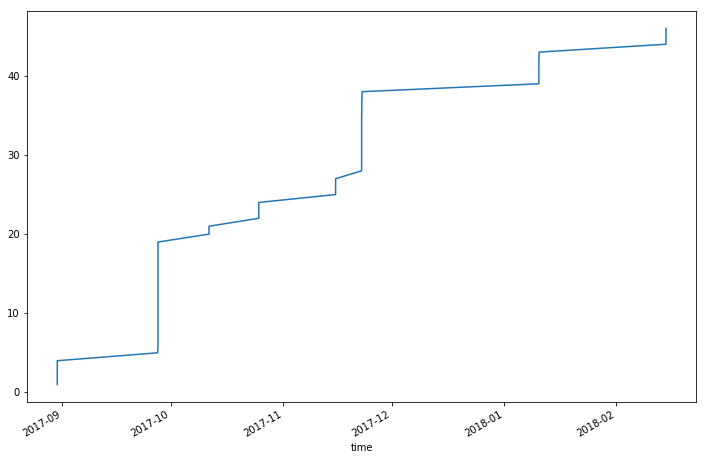

In [50]:
df[df.weekday == 'Onsdag'].touch.cumsum().plot();

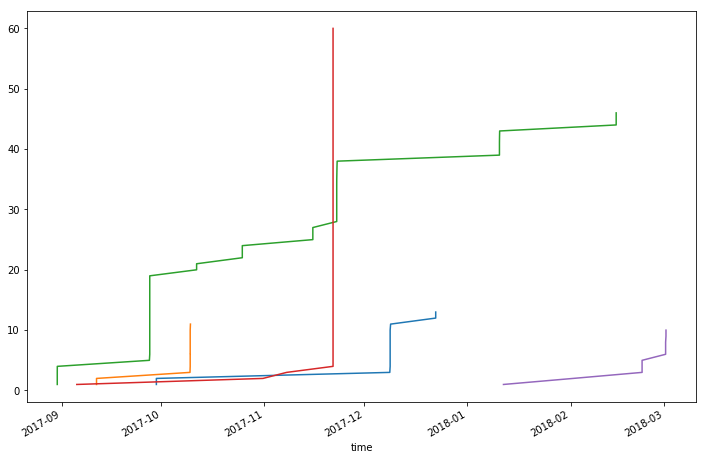

In [51]:
for (idx, group) in df.groupby('weekday'):
    group.object_present.cumsum().plot();

time
2017-09-29 12:18:33.194956521     1
2017-09-29 12:18:33.915822816     2
2017-12-08 16:10:29.669691797     3
2017-12-08 18:43:29.368384584     4
2017-12-08 18:43:30.658923891     5
2017-12-08 18:43:33.168388729     6
2017-12-08 18:43:33.658387590     7
2017-12-08 18:43:34.688721832     8
2017-12-08 18:43:35.178705058     9
2017-12-08 18:43:35.788256796    10
2017-12-08 22:05:51.028423366    11
2017-12-22 11:25:09.033493859    12
2017-12-22 11:25:09.593751336    13
Name: object_present, dtype: int32
time
2017-09-11 12:33:46.237692244     1
2017-09-11 12:33:46.738311177     2
2017-10-09 14:52:49.980703197     3
2017-10-09 16:19:12.720688057     4
2017-10-09 16:19:13.210576491     5
2017-10-09 16:19:14.980984981     6
2017-10-09 16:19:15.460441323     6
2017-10-09 16:19:15.950455559     7
2017-10-09 16:19:16.440669584     8
2017-10-09 16:19:16.930628431     9
2017-10-09 16:19:17.420678043    10
2017-10-09 18:03:04.241169214    11
Name: object_present, dtype: int32
time
2017-08-30 17:1

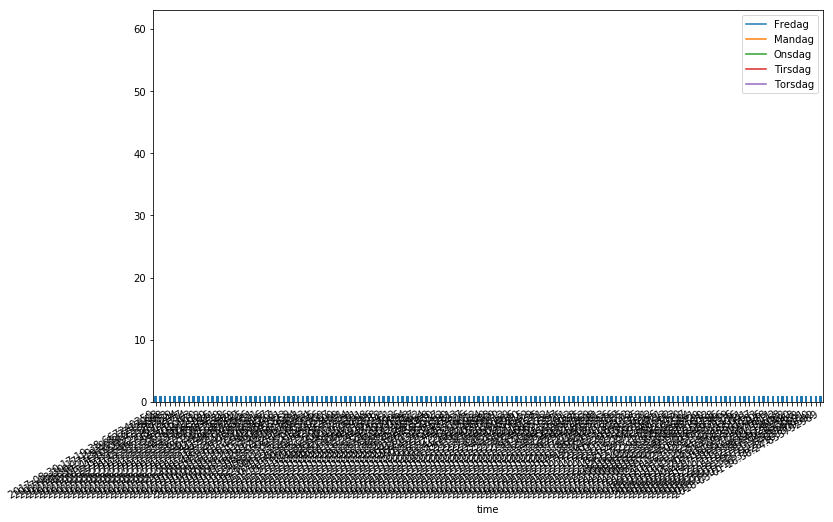

In [58]:
from matplotlib.pyplot import *

fig, ax = subplots()
df.plot(kind='bar', ax=ax)

legends = []
for (idx, group) in df.groupby('weekday'):
    print(group.object_present.cumsum())
    group.object_present.cumsum().plot(ax=ax);
    legends.append(idx)
ax.legend(legends);